In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import networkx as nx
from numba import njit
import imageio.v2 as imageio
import glob
from scipy.sparse import lil_matrix

import matplotlib
#matplotlib.use('Agg')

In [16]:
def bkg_img():

    plt.figure(figsize=(6, 4))
    bg_img = mpimg.imread('images/map_apple.png')
    ymin, xmin = [32.31, 34.44]
    ymax, xmax = [37.30, 42.77]
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.imshow(bg_img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

def bkg_blank():

    plt.figure(figsize=(6, 4))
    ymin, xmin = [32.31, 34.44]
    ymax, xmax = [37.30, 42.77]
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

 #make colormaps (register for magma_r, viridis_r)

mname = 'magma_r'
ncolors = 256
color_array = plt.get_cmap(mname)(range(ncolors))

# change alpha values
nlim = 30
color_array[:nlim,-1] = np.linspace(0.0,1.0,nlim)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name=f'{mname}_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.colormaps.register(cmap=map_object)

# show some example data
#f,ax = plt.subplots()
#h = ax.imshow(np.random.rand(100,100),cmap=map_object)
#plt.colorbar(mappable=h)

#### Import data

In [3]:
f = open('data/populated_places/datafile_oilscore_minorities.dat', "r")
next(f)
content = f.readlines()
f.close()
    
pop = []
x_coord  = []
y_coord  = []
oilscore = []
ethn_groups = []

for line in content:
    temp1 , temp2, temp3, temp4, *temp5 = line.strip().split()
    pop += [float(temp1)]
    x_coord  += [float(temp2)]
    y_coord  += [float(temp3)]
    oilscore += [float(temp4)]
    ethn_groups += [temp5]

x_coord = np.array(x_coord)
y_coord = np.array(y_coord)
pop = np.array(pop)
oilscore = np.array(oilscore)

In [4]:
adj_geom = np.loadtxt('adj_geom.txt')

print(adj_geom)

[[0.    0.016 0.726 ... 1.78  2.237 0.258]
 [0.016 0.    0.71  ... 1.795 2.251 0.27 ]
 [0.726 0.71  0.    ... 2.484 2.931 0.893]
 ...
 [1.78  1.795 2.484 ... 0.    0.466 1.726]
 [2.237 2.251 2.931 ... 0.466 0.    2.191]
 [0.258 0.27  0.893 ... 1.726 2.191 0.   ]]


In [5]:
thr = 0.1
adj_lim = adj_geom.copy()
adj_lim[adj_lim > thr] = 0

In [6]:
f = open('data/initial/init_occupier.dat', "r")
next(f)
content = f.readlines()
f.close()

init_occ = np.array([line.strip() for line in content])

f = open('data/betweenness_centrality/bce_values.txt', "r")
next(f)
content = f.readlines()
f.close()

bce_vals = np.array([float(line.strip()) for line in content])

f = open('data/closeness_centrality/closeness_values.txt', "r")
next(f)
content = f.readlines()
f.close()

closeness_vals = np.array([float(line.strip()) for line in content])

f = open('data/eigenvector_centrality/eigenvector_values.txt', "r")
next(f)
content = f.readlines()
f.close()

eigenvector_vals = np.array([float(line.strip()) for line in content])

fiedler_values = {}
with open("data/fiedler/fiedler_values.txt") as f:
    next(f)  # skip header
    for line in f:
        group, val = line.strip().split(",")
        fiedler_values[group] = float(val)

print(fiedler_values)

{'state': 0.0005792586450003632, 'sunni': 0.04534464452869004, 'kurds': 0.0016099047796869486}


In [7]:
G_geom = nx.from_numpy_array(adj_lim)
comps=sorted(nx.connected_components(G_geom))
largest_component = comps[0]
G_main = G_geom.subgraph(largest_component)

Important cities

In [8]:
cities = {'Damascus' : [36.29 , 33.51],
          'Aleppo'   : [37.10 , 36.12],
          'Homs'     : [36.72 , 34.73],
          'Ar Raqqah': [39.01 , 35.95],
          'Idlib'    : [36.63 , 35.93],
          'Dayr az Zawr' : [40.14 , 35.34],
          'Latakia'  : [35.79 , 35.53],
          'Tartous'  : [35.89 , 34.89]}

In [9]:
damascus_index = 6176
distances_from_damascus = adj_geom[damascus_index]
new_arr = distances_from_damascus[distances_from_damascus != 0.0]
#print(distances_from_damascus[1195])
print(np.argmax(new_arr))
print(distances_from_damascus[np.argmax(new_arr)])

#closeness_vals_nonzero=closeness_vals[closeness_vals != 0.0]
#print(np.argmax(closeness_vals))
#print(closeness_vals[np.argmax(closeness_vals)])

#print(closeness_vals[6177])

dam_norm = (distances_from_damascus - distances_from_damascus.min()) / \
           (distances_from_damascus.max() - distances_from_damascus.min())

print(dam_norm[1274])
#print(dam_norm[np.argmin(dam_norm)])

1274
3.542
1.0


#### Simulation

In [10]:
# parameters

eps_dist = 0.3 #0.3
c_pop = 0.01 #0.01
c_os = 4.21 #4.21
c_di = 0.76 #0.76
c_ethn = 3 #3
c_bce = 80 #80
c_dam=0.0001 #0.2
c_closeness= 30 #30/40
c_fiedler=45

In [ ]:
#First iteration algorithm
def charges_calc(occ_state):

    occ_state = np.asarray(occ_state)
    n = np.zeros(len(occ_state), dtype=float)

    for i in range(len(occ_state)):
        match = occ_state[i] in ethn_groups[i]      # True if the occupier matches a dominant ethnic group
        n[i] = 0.01*( pop[i] + 100 )*( 1 + 0.5*(float(match) - 0.5) )

    return n

def battle(I, J, prob, charg, occ_state):

    nI = prob*charg[I]     # attacker strength
    nJ = charg[J]          # defender strength
    diff = abs(nI-nJ)

    charg[I] -= nI         # attacker looses strength they mobilised

    if nI<=nJ:   
        charg[J] -= nI     # defender loses equal strength
    else:
        occ_state[J] = occ_state[I]
        charg[J] = diff  

    return charg, occ_state

def check_structural_collapse(occ_state, charges, loss_threshold, decay_factor):
  
    assad_nodes = np.where(occ_state == "state")[0]
    
    total_centrality = np.sum(eigenvector_vals[assad_nodes] + bce_vals[assad_nodes] + closeness_vals[assad_nodes])
    
    lost_nodes = np.where(occ_state != "state")[0]
    lost_centrality = np.sum(eigenvector_vals[lost_nodes] + bce_vals[lost_nodes] + closeness_vals[lost_nodes])
    
    if lost_centrality / total_centrality > loss_threshold:
        for node in assad_nodes:
            penalty = decay_factor + 0.5 * distances_from_damascus[node] 
            charges[node] *= max(0.2, 1 - penalty) 
    
    return charges

def iteration(init_state):
    final_state = init_state.copy()
    charges = charges_calc(init_state)

    half_pi = np.pi / 2

    for i in range(len(init_state)):
        neighbour_indices = np.nonzero(adj_lim[i])[0]

        if neighbour_indices.size == 0:
            continue

        # Get valid target neighbours (different occupier)
        mask_diff = init_state[neighbour_indices] != init_state[i]
        targets = neighbour_indices[mask_diff]

        if targets.size == 0:
            continue

        dam_distances = distances_from_damascus[targets]

        # Vectorised probability calculation
        p_pop = np.arctan(c_pop * pop[targets] + eps_dist) / half_pi
        p_os = 1 - np.arctan(c_os * oilscore[targets]) / half_pi
        p_dis = 1 -  np.arctan(c_di * adj_geom[i, targets]) / half_pi
        p_bce = np.arctan(c_bce * bce_vals[targets]) / half_pi
        p_closeness = np.arctan(c_closeness * closeness_vals[targets]) / half_pi
        p_eigenvector = eigenvector_vals[targets]
        p_damascus = 1 - np.arctan(c_dam*dam_distances) / half_pi

        probs = p_pop * p_os * p_dis * p_damascus
        
        # combine with logical ... AND ... OR ... 
        #p_os_dis = p_os + p_dis - p_os*p_dis                            
        #probs = p_pop * p_os_dis 

        # combine with logical ... OR ... AND ... 
        #p_os_dis = p_os * p_dis                             
        #probs = p_pop + p_os_dis - p_pop*p_os_dis

        # combine with logical ... OR ... OR ... 
        #p_os_dis = p_os + p_dis - p_os*p_dis                            
        #probs = p_pop + p_os_dis - p_pop*p_os_dis

        # centrality measures
        probs = probs + p_bce - probs*p_bce
        probs= probs + p_closeness - probs*p_closeness
        probs = probs + p_eigenvector - probs*p_eigenvector

        # Ethnic match bonus
        ethnic_match = np.array( [init_state[i] in ethn_groups[t] for t in targets] )
        probs[ethnic_match] = 1 - (1 - probs[ethnic_match]) / c_ethn

        invade_idx = np.argmax(probs)
        J = targets[invade_idx]

        charges, final_state = battle(i, J, probs[invade_idx], charges, final_state)
        #charges = check_structural_collapse(final_state, charges, loss_threshold=3, decay_factor=0.5)


    return final_state

def plot_state_frame(occ_state, I, save_frame):

    bkg_blank()

    ind_state = np.where(occ_state == "state")[0]
    ind_sunni = np.where(occ_state == "sunni")[0]
    ind_kurds = np.where(occ_state == "kurds")[0]

    x_state, y_state = [x_coord[ind_state],y_coord[ind_state]]
    x_sunni, y_sunni = [x_coord[ind_sunni],y_coord[ind_sunni]]
    x_kurds, y_kurds = [x_coord[ind_kurds],y_coord[ind_kurds]]

    if save_frame == False:
        plt.close('all')
        return [len(x_state),len(x_sunni),len(x_kurds)]

    heatmap, xedges, yedges = np.histogram2d(x_state, y_state, bins=300)
    plt.imshow( heatmap.T, origin='lower', cmap='ocean_r', 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
    );

    heatmap, xedges, yedges = np.histogram2d(x_sunni, y_sunni, bins=200)
    plt.imshow( heatmap.T, origin='lower', cmap='viridis_r_alpha', 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
    );

    heatmap, xedges, yedges = np.histogram2d(x_kurds, y_kurds, bins=200)
    plt.imshow( heatmap.T, origin='lower', cmap='magma_r_alpha', 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
    );

    plt.text(
        0.03, 0.9, f"{I+1}",
        transform=plt.gca().transAxes,
        fontsize=12, color='white',
        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3')
    )

    for city in cities:
        plt.scatter(cities[city][0], cities[city][1], c='black', s=1, marker='+')

    plt.savefig(f'images/frames/frame_{I+1}.png', bbox_inches = 'tight', dpi=300)
    plt.close('all')

    return [len(x_state),len(x_sunni),len(x_kurds)]


In [12]:
#Memory based algorithm
max_fiedler= max(fiedler_values.values())
rng = np.random.default_rng()


def compute_fiedler_values(occ_state, groups=['state', 'sunni', 'kurds']):
    fiedler_vals = {}

    for group in groups:
        group_nodes = np.where(occ_state == group)[0]

        if len(group_nodes) == 0:
            fiedler_vals[group] = 0.0
            continue

        G_group = G_geom.subgraph(group_nodes).copy()

        L_group = nx.laplacian_matrix(G_group).todense()
        eigenvalues_group = np.linalg.eigvalsh(L_group)

        # Takes the second-smallest eigenvalue (Fiedler value) of the Laplacian. 
        # We apply a numerical threshold to filter out values that are effectively zero 
        # due to floating-point precision, ensuring that only genuinely positive eigenvalues 
        # are considered. If none remain, we assign 0.0.
        valid_eig = eigenvalues_group[eigenvalues_group > 3.08e-13]
        fiedler_val = np.min(valid_eig) if len(valid_eig) > 0 else 0.0
        fiedler_vals[group] = fiedler_val

    return fiedler_vals





multipliers_base = {'state':1.0, 'sunni':1.0,'kurds':1.0}
def charges_calc_memory(occ_state, apply_fiedler_init=True, fiedler_init=None):
    occ_state = np.asarray(occ_state)
    n = np.zeros(len(occ_state), dtype=float)

    #factions = np.unique(occ_state)
    #supply_factor = {}

    #for f in factions:
     #   total_initial = np.sum(np.array(occ_state) == f)
     #   total_now = np.sum(occ_state == f)
     #   lost_frac = 1 - total_now / total_initial if total_initial > 0 else 0
     #   supply_factor[f] = max(0.1,  lost_frac)  # min 20%

    for i in range(len(occ_state)):
        faction = occ_state[i]
        match = faction in ethn_groups[i] #True if the occupier matches a dominant ethnic group

        base = 0.01 * (pop[i] + 100) * (1 + 0.5 * (float(match) - 0.5)) 

        mul = multipliers_base.get(faction, 1.0) 
        
        if apply_fiedler_init and fiedler_init is not None:
            fval = fiedler_init.get(faction, 0.0)
            fscale = (fval / max_fiedler)  # in [0.5,1]
            mul *= fscale
            
            n[i] = base * mul

        else:
            #base *= supply_factor.get(faction, 1.0)  
            n[i] = base 

    return n

def check_structural_collapse(occ_state, charges, loss_threshold, decay_factor):
  
    state_nodes = np.where(occ_state == "state")[0]
    
    total_centrality = np.sum(eigenvector_vals[state_nodes] + bce_vals[state_nodes] + closeness_vals[state_nodes])
    
    lost_nodes = np.where(occ_state != "state")[0]
    lost_centrality = np.sum(eigenvector_vals[lost_nodes] + bce_vals[lost_nodes] + closeness_vals[lost_nodes])
    print('Ratio:' , lost_centrality / total_centrality)
    
    #If the loss exceeds the threshold → collapse
    if lost_centrality / total_centrality > loss_threshold:
        for node in state_nodes:
            #Penalizes more the nodes far from Damascus
            penalty = decay_factor + 0.5 * distances_from_damascus[node]  
            charges[node] *= max(0.2, 0.5 - penalty)  
    
    return charges



def battle(I, J, prob, charg, occ_state, attacker_label):
   # def_factor = dynamic_def_factor(occ_state, attacker_label)
    nI = prob*charg[I]     # attacker strength
    nJ = charg[J]  #* def_factor   # defender strength
    diff = abs(nI-nJ)

    charg[I] -= nI

    if nI<=nJ:   
        charg[J] -= nI     # defender loses equal strength
    else:
        occ_state[J] = occ_state[I]
        charg[J] = diff  

    return charg, occ_state


def iteration(init_state, charges, iter):
    final_state = init_state.copy()
    half_pi = np.pi / 2

    n = len(init_state)
    T = lil_matrix((n, n), dtype=float)   
    planned_attacks = []


    for i in range(n):
        neighbour_indices = np.nonzero(adj_lim[i])[0]
        if neighbour_indices.size == 0:
            T[i, i] = 1.0
            continue

        

        # Get valid target neighbours (different occupier)
        mask_diff = final_state[neighbour_indices] != final_state[i]
        targets = neighbour_indices[mask_diff]
        mask_diff = final_state[neighbour_indices] == final_state[i]
        friends = neighbour_indices[mask_diff]
        if targets.size == 0:
            continue

        dam_distances = distances_from_damascus[targets]

        # Vectorised probability calculation
        p_pop = np.arctan(c_pop * pop[targets] + eps_dist) / half_pi
        p_os = 1 - np.arctan(c_os * oilscore[targets]) / half_pi
        p_dis = 1 -  np.arctan(c_di * adj_geom[i, targets]) / half_pi
        p_bce = np.arctan(c_bce * bce_vals[targets]) / half_pi
        p_closeness = np.arctan(c_closeness * closeness_vals[targets]) / half_pi
        p_eigenvector = eigenvector_vals[targets]
        #p_damascus = 1 - np.arctan(c_dam*dam_distances) / half_pi

        # combine with logical ... AND ... AND ...
        probs = p_pop * p_os * p_dis #* p_damascus
        
        # combine with logical ... AND ... OR ... 
        #p_os_dis = p_os + p_dis - p_os*p_dis                            
        #probs = p_pop * p_os_dis 

        # combine with logical ... OR ... AND ... 
        #p_os_dis = p_os * p_dis                             
        #probs = p_pop + p_os_dis - p_pop*p_os_dis

        # combine with logical ... OR ... OR ... 
        #p_os_dis = p_os + p_dis - p_os*p_dis                            
        #probs = p_pop + p_os_dis - p_pop*p_os_dis

        # betweeness centrality
        probs = probs + p_bce - probs*p_bce
        probs= probs + p_closeness - probs*p_closeness
        probs = probs + p_eigenvector - probs*p_eigenvector

        
        # Ethnic match bonus
        ethnic_match = np.array( [init_state[i] in ethn_groups[t] for t in targets] )
        if ethnic_match.any():
            probs[ethnic_match] = 1 - (1 - probs[ethnic_match]) / c_ethn
        
        
        dist_neigh = adj_geom[i, friends]
        w_move = np.exp(-2 * dist_neigh)
        eig_neigh = eigenvector_vals[friends]
        clo_neigh = closeness_vals[friends]   
        bce_neigh = bce_vals[friends]
        w_move *= (1 + 2 * eig_neigh) * (1 + 5 * clo_neigh) * (1 + 3 * bce_neigh)
        

        s = w_move.sum()
        if s <= 0:
            # fallback: self loop
            T[i, i] = 1.0
        else:
            w_norm = w_move / s
            T[i, friends] = w_norm  #assign row i
        
        #


        p_attack = probs / probs.sum()
        
        #extract a stochastic target J and save the attack 
        J = rng.choice(targets, p=p_attack)
        prob_on_J = probs[targets == J][0]
        planned_attacks.append((i, int(J), float(prob_on_J)))

    T_csr = T.tocsr()
    moved = T_csr.T.dot(charges)    #T^T @ charges
    charges = (1-0.3)* charges + 0.3 * moved

    for (i, J, p_on_J) in planned_attacks:
        charges, final_state = battle(i, J, p_on_J, charges, final_state, final_state[i])
        #charges = check_structural_collapse(final_state, charges, loss_threshold=17, decay_factor=0.3)

    


    return final_state, charges

def plot_state_frame(occ_state, I, save_frame):

    bkg_blank()

    ind_state = np.where(occ_state == "state")[0]
    ind_sunni = np.where(occ_state == "sunni")[0]
    ind_kurds = np.where(occ_state == "kurds")[0]

    x_state, y_state = [x_coord[ind_state],y_coord[ind_state]]
    x_sunni, y_sunni = [x_coord[ind_sunni],y_coord[ind_sunni]]
    x_kurds, y_kurds = [x_coord[ind_kurds],y_coord[ind_kurds]]

    if save_frame == False:
        plt.close('all')
        return [len(x_state),len(x_sunni),len(x_kurds)]

    heatmap, xedges, yedges = np.histogram2d(x_state, y_state, bins=300)
    plt.imshow( heatmap.T, origin='lower', cmap='ocean_r', 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
    );

    heatmap, xedges, yedges = np.histogram2d(x_sunni, y_sunni, bins=200)
    plt.imshow( heatmap.T, origin='lower', cmap='viridis_r_alpha', 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
    );

    heatmap, xedges, yedges = np.histogram2d(x_kurds, y_kurds, bins=200)
    plt.imshow( heatmap.T, origin='lower', cmap='magma_r_alpha', 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
    );

    plt.text(
        0.03, 0.9, f"{I+1}",
        transform=plt.gca().transAxes,
        fontsize=12, color='white',
        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3')
    )

    for city in cities:
        plt.scatter(cities[city][0], cities[city][1], c='black', s=1, marker='+')

    plt.savefig(f'images/frames/frame_{I+1}.png', bbox_inches = 'tight', dpi=300)
    plt.close('all')

    return [len(x_state),len(x_sunni),len(x_kurds)]


In [ ]:
#Main loop first iteration
N = 100
init_state = init_occ.copy()
occ_nums = np.zeros((3,N))

# Note: if colormap error occurs, run cell 2 by unhashing the registry line for 'magma' and 'viridis'

for iter in tqdm(range(N)):

    out_state = iteration(init_state)
    occ_nums[:,iter] = plot_state_frame(out_state,iter)
    init_state = out_state.copy()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


In [ ]:
#Main loop with memory iteration
N = 100
init_state = init_occ.copy()
fiedler_init = compute_fiedler_values(init_state) 
charges = charges_calc_memory(init_state, apply_fiedler_init=True, fiedler_init=fiedler_init)
occ_nums = np.zeros((3,N))

# Note: if colormap error occurs, run cell 2 by unhashing the registry line for 'magma' and 'viridis'

for iter in tqdm(range(N)):
    new_recruit = charges_calc_memory(init_state, apply_fiedler_init=False)
    charges = 0.94 * charges + 0.06 * new_recruit

    out_state, charges = iteration(init_state, charges,iter)
    occ_nums[:,iter] = plot_state_frame(out_state,iter)
    init_state = out_state.copy()

100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


In [187]:
frame_files = sorted(glob.glob("images/frames/frame_*.png"), key=lambda f: int(f.split('_')[-1].split('.')[0]))

# Read and save as GIF
frames = [imageio.imread(f) for f in frame_files]
imageio.mimsave("images/animations/animation_test.gif", frames, duration=0.4) 

## Simulation as function of the parameters for simple iteration algorithm

In [11]:
# normalised data


pop_norm = pop/max(pop)
oilscore_norm = oilscore/max(oilscore)
bce_vals_norm = bce_vals/max(bce_vals)
adj_lim_norm = adj_lim/np.max(adj_lim)
adj_geom_norm = adj_geom/np.max(adj_geom)
closeness_vals_norm = closeness_vals/max(closeness_vals)
dam_norm = distances_from_damascus / distances_from_damascus.max()

half_pi = np.pi / 2

In [ ]:
def simulation(Num_iter, e_dist, a_pop, a_os, a_di, a_ethn, a_bce, save_frame_option):

    init_state = init_occ.copy()
    occ_nums = np.zeros((3,Num_iter))

    for iter in tqdm(range(Num_iter)):

        final_state = init_state.copy()
        charges = charges_calc(init_state)

        for i in range(len(init_state)):
            neighbour_indices = np.nonzero(adj_lim[i])[0]

            if neighbour_indices.size == 0:
                continue

            # Get valid target neighbours (different occupier)
            mask_diff = init_state[neighbour_indices] != init_state[i]
            targets = neighbour_indices[mask_diff]

            if targets.size == 0:
                continue

            # Vectorised probability calculation
            p_pop = np.arctan(a_pop * pop_norm[targets] + e_dist) / half_pi
            p_os  = 1 - np.arctan(a_os * oilscore_norm[targets]) / half_pi
            p_dis = 1 -  np.arctan(a_di * adj_geom_norm[i, targets]) / half_pi
            p_bce = np.arctan(a_bce * bce_vals_norm[targets]) / half_pi 

            # combine with logical ... AND ... AND ...
            probs = p_pop * p_os * p_dis

            # betweeness centrality (OR)
            probs = probs + p_bce - probs*p_bce

            # Ethnic match bonus
            ethnic_match = np.array( [init_state[i] in ethn_groups[t] for t in targets] )
            probs[ethnic_match] = 1 - (1 - probs[ethnic_match]) / a_ethn

            invade_idx = np.argmax(probs)
            J = targets[invade_idx]

            charges, final_state = battle(i, J, probs[invade_idx], charges, final_state)

        occ_nums[:,iter] = plot_state_frame(final_state, iter, save_frame=save_frame_option)
        init_state = final_state.copy()

    return occ_nums[:,-1]

In [ ]:
simulation(40, 0.3, 0.01*max(pop), 4.21*max(oilscore), 0.76*np.max(adj_lim), 3, 80*max(bce_vals), True)

### Range of parameter values

Logarithmic range of values for the various $c$ parameters in $\arctan(c x)$ where $x \in [0,1]$ is normalised data. Typically from $c=1$ to $c=10^2$ with $2 \arctan(1)/ \pi = 0.5$ to $2 \arctan(10^2)/ \pi \approx 0.994$ unless modified differently.

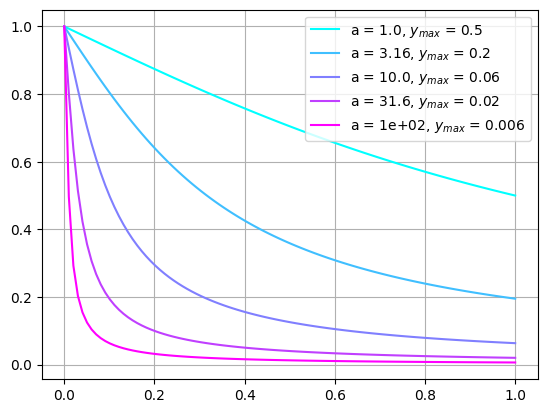

In [43]:
xrange = np.linspace(0,1,100)
for a in np.logspace(0,2,5):
    plt.plot(xrange, 1-2*np.arctan(a*xrange)/np.pi, label = f'a = {a:.3}, $y_{{max}}$ = {1-2*np.arctan(a)/np.pi:.1}', color = cm.cool(np.log10(a)/2))
plt.legend()
plt.grid()

In [107]:
a_pop_ls = np.logspace(2,6,15)
a_di_ls  = np.logspace(-2,2,15)
a_os_ls  = np.logspace(0,2,15)
a_bce_ls = np.logspace(0,2,15)

### $c_{pop}$ - $c_{dis}$

In [ ]:
final_count_state = np.zeros((len(a_di_ls), len(a_pop_ls)))
final_count_sunni = np.zeros((len(a_di_ls), len(a_pop_ls)))
final_count_kurds = np.zeros((len(a_di_ls), len(a_pop_ls)))

for i, y in enumerate(a_di_ls):
    for j, x in enumerate(a_pop_ls):
        # simulation(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, save frame)
        result = simulation(30, 0.3, x, 7.44, y, 3, 9.51, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results/pop_dis_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results/pop_dis_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results/pop_dis_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_pop_ls = np.logspace(2,6,15)
a_di_ls  = np.logspace(-2,2,15)

final_perc_sunni = np.loadtxt("results/pop_dis_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results/pop_dis_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_pop_ls[0], a_pop_ls[-1], len(a_pop_ls) + 1)
y_edges = np.geomspace(a_di_ls[0], a_di_ls[-1], len(a_di_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{pop}$')
axes[0].set_ylabel('$c_{dis}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{pop}$')
axes[1].set_ylabel('$c_{dis}$')
axes[1].set_title('State Occupied Regions')


axes[0].scatter(21321, 0.076, c = 'red')
axes[1].scatter(21321, 0.076, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/pop_dis.png', bbox_inches = 'tight', dpi=300)

### $c_{pop}$ - $c_{os}$

In [ ]:
final_count_state = np.zeros((len(a_os_ls), len(a_pop_ls)))
final_count_sunni = np.zeros((len(a_os_ls), len(a_pop_ls)))
final_count_kurds = np.zeros((len(a_os_ls), len(a_pop_ls)))

for i, y in enumerate(a_os_ls):
    for j, x in enumerate(a_pop_ls):
        # simulation(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, save frame)
        result = simulation(30, 0.3, x, y, 0.076, 3, 9.51, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results/pop_os_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results/pop_os_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results/pop_os_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

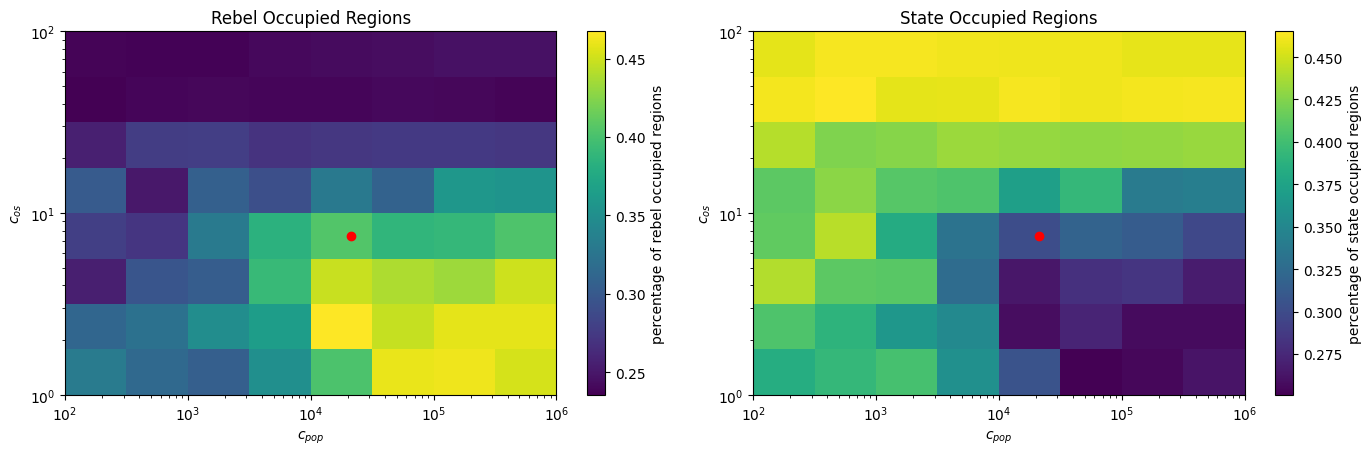

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_pop_ls = np.logspace(2,6,15)
a_os_ls  = np.logspace(0,2,15)

final_perc_sunni = np.loadtxt("results/pop_os_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results/pop_os_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_pop_ls[0], a_pop_ls[-1], len(a_pop_ls) + 1)
y_edges = np.geomspace(a_os_ls[0], a_os_ls[-1], len(a_os_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{pop}$')
axes[0].set_ylabel('$c_{os}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{pop}$')
axes[1].set_ylabel('$c_{os}$')
axes[1].set_title('State Occupied Regions')

axes[0].scatter(21321, 7.44, c = 'red')
axes[1].scatter(21321, 7.44, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/pop_os.png', bbox_inches = 'tight', dpi=300)

### $c_{dis}$ - $c_{os}$

In [ ]:
final_count_state = np.zeros((len(a_os_ls), len(a_di_ls)))
final_count_sunni = np.zeros((len(a_os_ls), len(a_di_ls)))
final_count_kurds = np.zeros((len(a_os_ls), len(a_di_ls)))

for i, y in enumerate(a_os_ls):
    for j, x in enumerate(a_di_ls):
        # simulation(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, save frame)
        result = simulation(30, 0.3, 21321, y, x, 3, 9.51, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results/dis_os_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results/dis_os_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results/dis_os_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

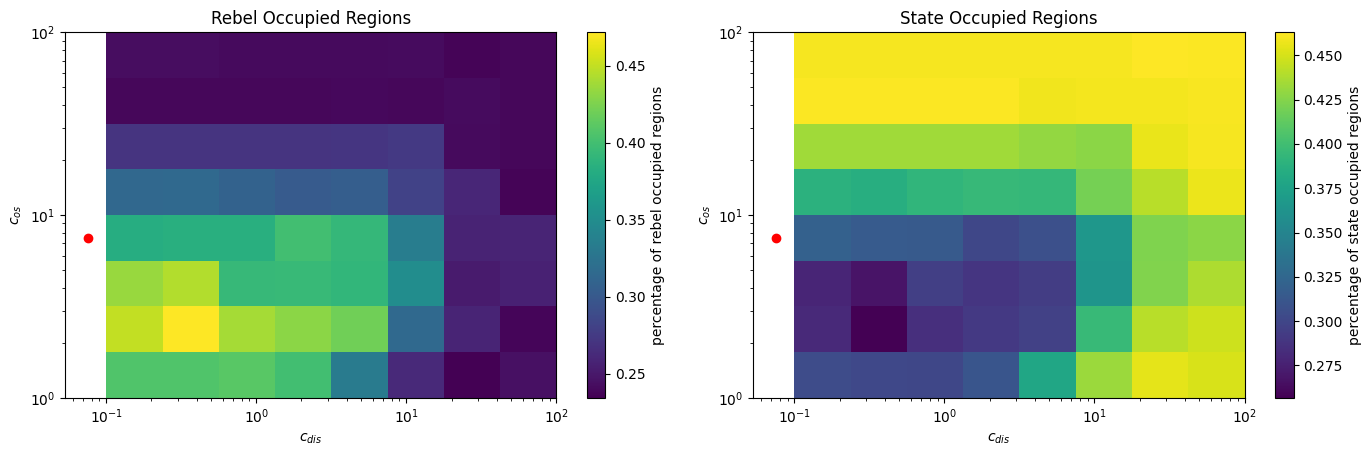

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_di_ls  = np.logspace(-2,2,15)
a_os_ls  = np.logspace(0,2,15)

final_perc_sunni = np.loadtxt("results/dis_os_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results/dis_os_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_di_ls[0], a_di_ls[-1], len(a_di_ls) + 1)
y_edges = np.geomspace(a_os_ls[0], a_os_ls[-1], len(a_os_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{dis}$')
axes[0].set_ylabel('$c_{os}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{dis}$')
axes[1].set_ylabel('$c_{os}$')
axes[1].set_title('State Occupied Regions')

axes[0].scatter(0.076, 7.44, c = 'red')
axes[1].scatter(0.076, 7.44, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/dis_os.png', bbox_inches = 'tight', dpi=300)

## Simulation as function of the parameters for Memory-based iteration algorithm

In [ ]:
def simulation_memory(Num_iter, e_dist, a_pop, a_os, a_di, a_ethn, a_bce, a_closeness, a_dam, save_frame_option):
    init_state = init_occ.copy()
    occ_nums = np.zeros((3,Num_iter))
    fiedler_init = fiedler_values.copy()
    charges = charges_calc_memory(init_state, apply_fiedler_init=True, fiedler_init=fiedler_init)
    half_pi = np.pi / 2    


    for iter in tqdm(range(Num_iter)):
        final_state = init_state.copy()
        half_pi = np.pi / 2

        n = len(init_state)
        T = lil_matrix((n, n), dtype=float)   
        planned_attacks = []


        for i in range(n):
            neighbour_indices = np.nonzero(adj_lim[i])[0]
            if neighbour_indices.size == 0:
                T[i, i] = 1.0
                continue

            

            # Get valid target neighbours (different occupier)
            mask_diff = final_state[neighbour_indices] != final_state[i]
            targets = neighbour_indices[mask_diff]
            mask_diff = final_state[neighbour_indices] == final_state[i]
            friends = neighbour_indices[mask_diff]
            if targets.size == 0:
                continue

            dam_distances = distances_from_damascus[targets]

            # Vectorised probability calculation
            p_pop = np.arctan( a_pop* pop_norm[targets] + e_dist) / half_pi
            p_os = 1 - np.arctan(a_os * oilscore_norm[targets]) / half_pi
            p_dis = 1 -  np.arctan(a_di * adj_geom_norm[i, targets]) / half_pi
            p_bce = np.arctan(a_bce * bce_vals_norm[targets]) / half_pi
            p_closeness = np.arctan(a_closeness * closeness_vals_norm[targets]) / half_pi
            p_eigenvector = eigenvector_vals[targets]
            p_damascus = 1 - np.arctan(a_dam*dam_norm) / half_pi

            # combine with logical ... AND ... AND ...
            probs = p_pop * p_os * p_dis * p_damascus
            
            # combine with logical ... AND ... OR ... 
            #p_os_dis = p_os + p_dis - p_os*p_dis                            
            #probs = p_pop * p_os_dis 

            # combine with logical ... OR ... AND ... 
            #p_os_dis = p_os * p_dis                             
            #probs = p_pop + p_os_dis - p_pop*p_os_dis

            # combine with logical ... OR ... OR ... 
            #p_os_dis = p_os + p_dis - p_os*p_dis                            
            #probs = p_pop + p_os_dis - p_pop*p_os_dis

            # betweeness centrality
            probs = probs + p_bce - probs*p_bce
            probs= probs + p_closeness - probs*p_closeness
            probs = probs + p_eigenvector - probs*p_eigenvector

            
            # Ethnic match bonus
            ethnic_match = np.array( [init_state[i] in ethn_groups[t] for t in targets] )
            if ethnic_match.any():
                probs[ethnic_match] = 1 - (1 - probs[ethnic_match]) / a_ethn
            
            
            dist_neigh = adj_geom[i, friends]
            w_move = np.exp(-2 * dist_neigh)
            eig_neigh = eigenvector_vals[friends]
            clo_neigh = closeness_vals[friends]   
            bce_neigh = bce_vals[friends]
            w_move *= (1 + 2 * eig_neigh) * (1 + 5 * clo_neigh) * (1 + 3 * bce_neigh)
            

            s = w_move.sum()
            if s <= 0:
                # fallback: self loop
                T[i, i] = 1.0
            else:
                w_norm = w_move / s
                T[i, friends] = w_norm  #assign row i
            
            #


            p_attack = probs / probs.sum()
            
            #extract a stochastic target J and save the attack 
            J = rng.choice(targets, p=p_attack)
            prob_on_J = probs[targets == J][0]
            planned_attacks.append((i, int(J), float(prob_on_J)))

        T_csr = T.tocsr()
        moved = T_csr.T.dot(charges)    #T^T @ charges
        charges = (1-0.3)* charges + 0.3 * moved

        for (i, J, p_on_J) in planned_attacks:
            charges, final_state = battle(i, J, p_on_J, charges, final_state, final_state[i])
        #charges = check_structural_collapse(final_state, charges, loss_threshold=17, decay_factor=0.3)

        new_recruit = charges_calc_memory(init_state, apply_fiedler_init=False)
        charges = 0.999 * charges + 0.001 * new_recruit
        occ_nums[:,iter] = plot_state_frame(final_state, iter, save_frame=save_frame_option)
        init_state = final_state.copy()
        
    return occ_nums[:,-1]

In [ ]:
simulation_memory(100, 0.3, 0.01*max(pop), 4.21*max(oilscore), 0.76*np.max(adj_lim), 3, 37, 100, 3.72, True)

100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


array([ 839., 5216., 1955.])

### Range of parameter values

Logarithmic range of values for the various $c$ parameters in $\arctan(c x)$ where $x \in [0,1]$ is normalised data. Typically from $c=1$ to $c=10^2$ with $2 \arctan(1)/ \pi = 0.5$ to $2 \arctan(10^2)/ \pi \approx 0.994$ unless modified differently.

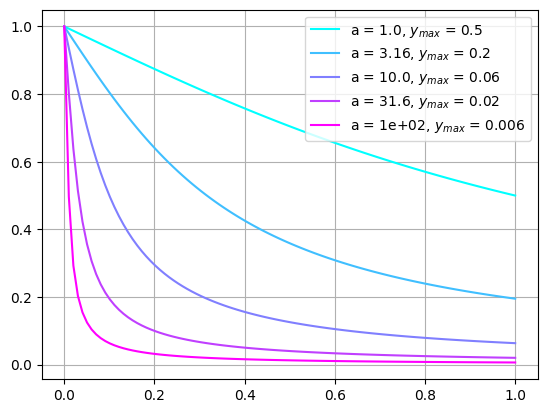

In [47]:
xrange = np.linspace(0,1,100)
for a in np.logspace(0,2,5):
    plt.plot(xrange, 1-2*np.arctan(a*xrange)/np.pi, label = f'a = {a:.3}, $y_{{max}}$ = {1-2*np.arctan(a)/np.pi:.1}', color = cm.cool(np.log10(a)/2))
plt.legend()
plt.grid()

In [108]:
a_pop_ls = np.logspace(2,6,10)
a_di_ls  = np.logspace(-2,2,15)
a_os_ls  = np.logspace(0,2,15)
a_bce_ls = np.logspace(0,2,15)
a_cce_ls = np.logspace(0,2,15)
a_dam_ls = np.logspace(-1,1,15)
a_ethn_ls = np.linspace(1,5,10)

### $c_{pop}$ - $c_{ethn}$

In [109]:
final_count_state = np.zeros((len(a_ethn_ls), len(a_pop_ls)))
final_count_sunni = np.zeros((len(a_ethn_ls), len(a_pop_ls)))
final_count_kurds = np.zeros((len(a_ethn_ls), len(a_pop_ls)))

for i, y in enumerate(a_ethn_ls):
    for j, x in enumerate(a_pop_ls):
        # simulation_memory(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, 3.03, 0.1, save frame)
        result = simulation_memory(35, 0.3, x, 7.44, 0.076, y, 9.51, 3.03, 0.1, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results_memory/pop_ethn_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/pop_ethn_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/pop_ethn_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

100%|██████████| 35/35 [00:23<00:00,  1.49it/s]


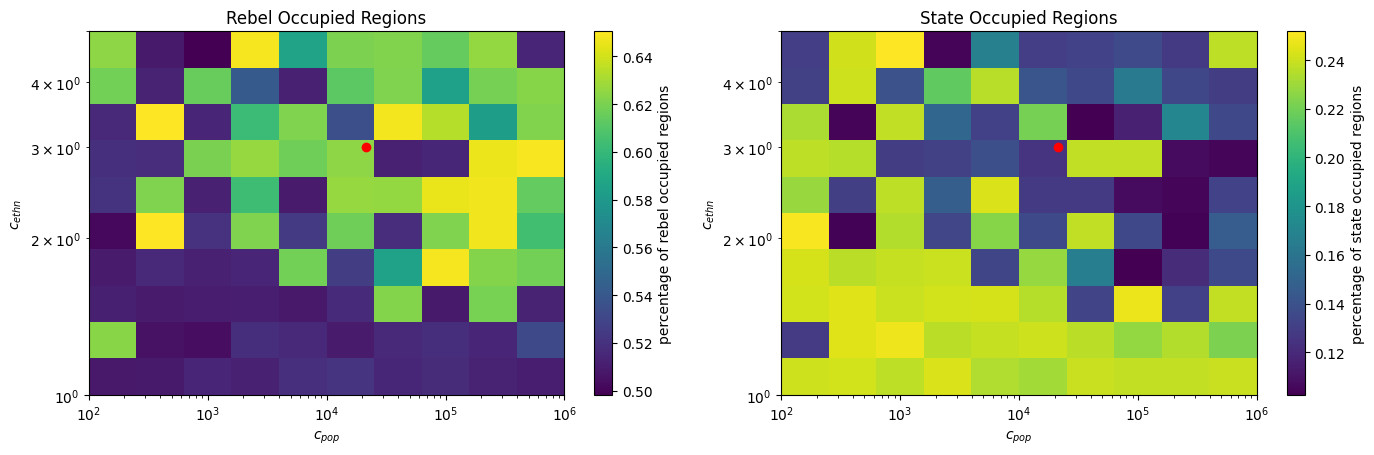

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_pop_ls = np.logspace(2,6,10)
a_ethn_ls = np.linspace(1,5,10)

final_perc_sunni = np.loadtxt("results_memory/pop_ethn_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results_memory/pop_ethn_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_pop_ls[0], a_pop_ls[-1], len(a_pop_ls) + 1)
y_edges = np.geomspace(a_ethn_ls[0], a_ethn_ls[-1], len(a_ethn_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{pop}$')
axes[0].set_ylabel('$c_{ethn}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{pop}$')
axes[1].set_ylabel('$c_{ethn}$')
axes[1].set_title('State Occupied Regions')


axes[0].scatter(21321, 3, c = 'red')
axes[1].scatter(21321, 3, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/pop_ethn_mem.png', bbox_inches = 'tight', dpi=300)

### $c_{pop}$ - $c_{dis}$

In [105]:
final_count_state = np.zeros((len(a_di_ls), len(a_pop_ls)))
final_count_sunni = np.zeros((len(a_di_ls), len(a_pop_ls)))
final_count_kurds = np.zeros((len(a_di_ls), len(a_pop_ls)))

for i, y in enumerate(a_di_ls):
    for j, x in enumerate(a_pop_ls):
        # simulation_memory(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, 3.03, 0.1, save frame)
        result = simulation_memory(35, 0.3, x, 7.44, y, 3, 9.51, 3.03, 0.1, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results_memory/pop_dis_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/pop_dis_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/pop_dis_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

100%|██████████| 35/35 [00:27<00:00,  1.26it/s]


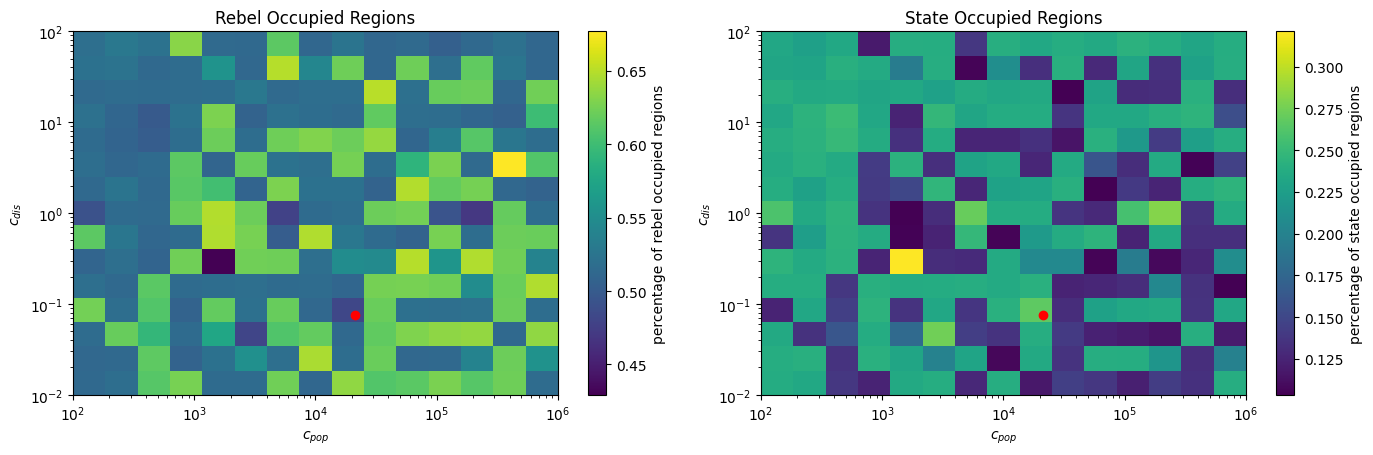

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_pop_ls = np.logspace(2,6,15)
a_di_ls  = np.logspace(-2,2,15)

final_perc_sunni = np.loadtxt("results_memory/pop_dis_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results_memory/pop_dis_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_pop_ls[0], a_pop_ls[-1], len(a_pop_ls) + 1)
y_edges = np.geomspace(a_di_ls[0], a_di_ls[-1], len(a_di_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{pop}$')
axes[0].set_ylabel('$c_{dis}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{pop}$')
axes[1].set_ylabel('$c_{dis}$')
axes[1].set_title('State Occupied Regions')


axes[0].scatter(21321, 0.076, c = 'red')
axes[1].scatter(21321, 0.076, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/pop_dis_mem.png', bbox_inches = 'tight', dpi=300)

### $c_{pop}$ - $c_{os}$

In [91]:
final_count_state = np.zeros((len(a_os_ls), len(a_pop_ls)))
final_count_sunni = np.zeros((len(a_os_ls), len(a_pop_ls)))
final_count_kurds = np.zeros((len(a_os_ls), len(a_pop_ls)))

for i, y in enumerate(a_os_ls):
    for j, x in enumerate(a_pop_ls):
        # simulation_memory(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, 3.03, 0.1, save frame)
        result = simulation_memory(35, 0.3, x, y, 0.076, 3, 9.51, 3.03, 0.1, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results_memory/pop_os_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/pop_os_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/pop_os_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:47<00:00,  1.36s/it]


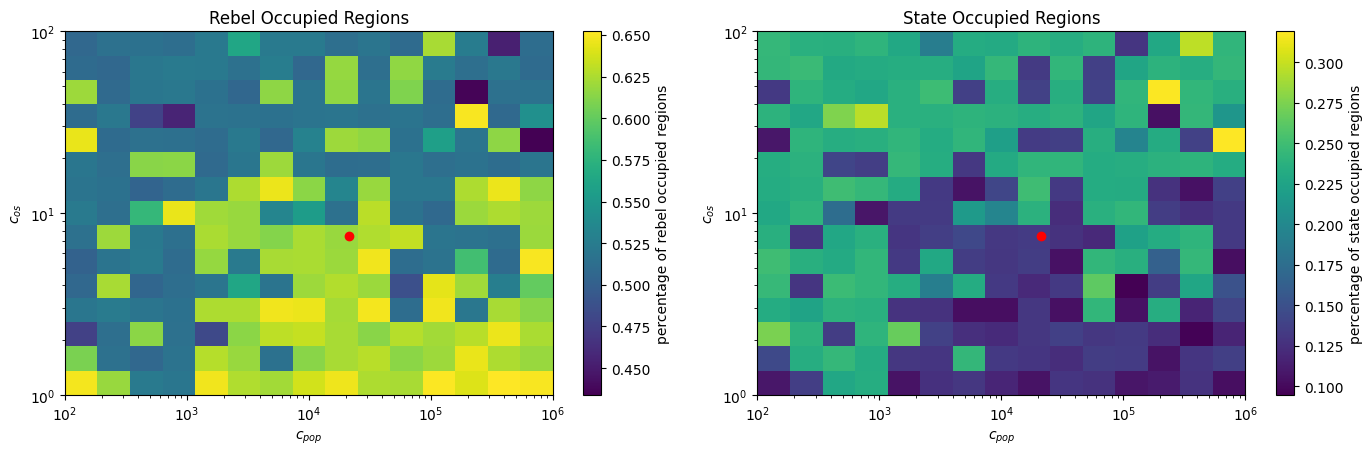

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_pop_ls = np.logspace(2,6,15)
a_os_ls  = np.logspace(0,2,15)

final_perc_sunni = np.loadtxt("results_memory/pop_os_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results_memory/pop_os_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_pop_ls[0], a_pop_ls[-1], len(a_pop_ls) + 1)
y_edges = np.geomspace(a_os_ls[0], a_os_ls[-1], len(a_os_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{pop}$')
axes[0].set_ylabel('$c_{os}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{pop}$')
axes[1].set_ylabel('$c_{os}$')
axes[1].set_title('State Occupied Regions')

axes[0].scatter(21321, 7.44, c = 'red')
axes[1].scatter(21321, 7.44, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/pop_os_mem.png', bbox_inches = 'tight', dpi=300)

### $c_{dis}$ - $c_{os}$

In [102]:
final_count_state = np.zeros((len(a_os_ls), len(a_di_ls)))
final_count_sunni = np.zeros((len(a_os_ls), len(a_di_ls)))
final_count_kurds = np.zeros((len(a_os_ls), len(a_di_ls)))

for i, y in enumerate(a_os_ls):
    for j, x in enumerate(a_di_ls):
         # simulation_memory(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, 3.03, 0.1, save frame)
        result = simulation_memory(35, 0.3, 21321, y, x, 3, 9.51, 3.03, 0.1, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results_memory/dis_os_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/dis_os_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/dis_os_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:44<00:00,  1.27s/it]


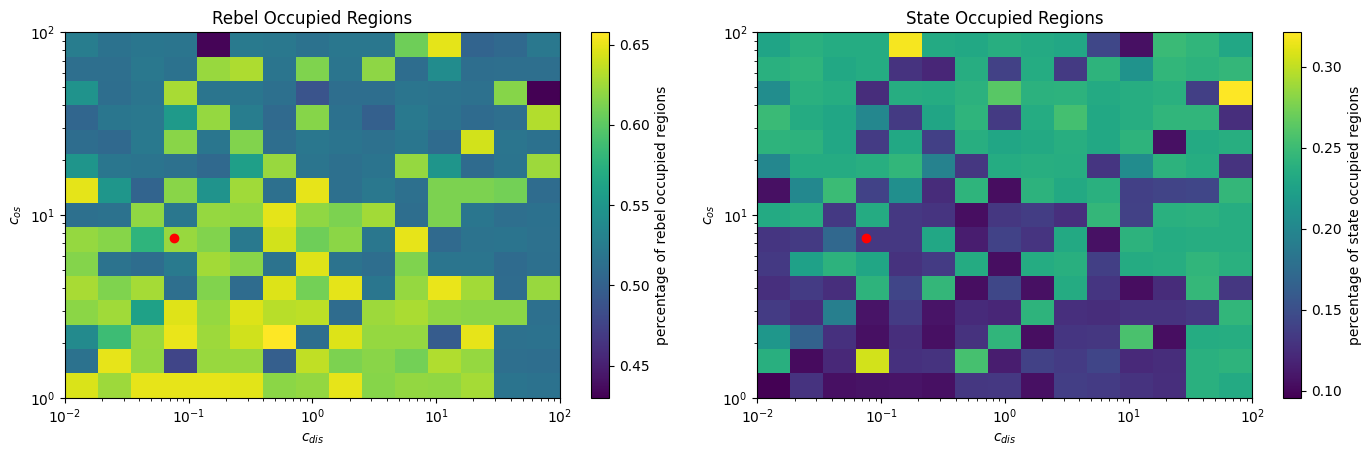

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_di_ls  = np.logspace(-2,2,15)
a_os_ls  = np.logspace(0,2,15)

final_perc_sunni = np.loadtxt("results_memory/dis_os_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results_memory/dis_os_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_di_ls[0], a_di_ls[-1], len(a_di_ls) + 1)
y_edges = np.geomspace(a_os_ls[0], a_os_ls[-1], len(a_os_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{dis}$')
axes[0].set_ylabel('$c_{os}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{dis}$')
axes[1].set_ylabel('$c_{os}$')
axes[1].set_title('State Occupied Regions')

axes[0].scatter(0.076, 7.44, c = 'red')
axes[1].scatter(0.076, 7.44, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/dis_os_mem.png', bbox_inches = 'tight', dpi=300)

### $c_{bce}$ - $c_{cce}$

In [64]:
final_count_state = np.zeros((len(a_cce_ls), len(a_bce_ls)))
final_count_sunni = np.zeros((len(a_cce_ls), len(a_bce_ls)))
final_count_kurds = np.zeros((len(a_cce_ls), len(a_bce_ls)))

for i, y in enumerate(a_cce_ls):
    for j, x in enumerate(a_bce_ls):
# simulation_memory(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, 3.03, 0.1, save frame)
        result = simulation_memory(35, 0.3, 21321, 7.44, 0.076, 3, x, y, 0.1, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results_memory/bce_cce_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/bce_cce_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/bce_cce_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:32<00:00,  1.07it/s]


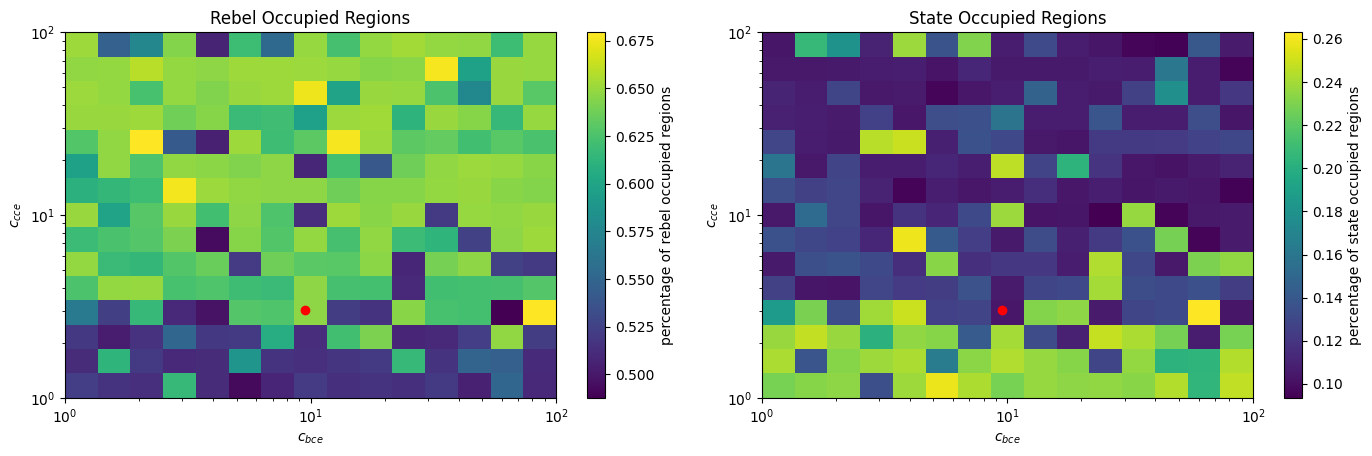

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_bce_ls = np.logspace(0,2,15)
a_cce_ls = np.logspace(0,2,15)

final_perc_sunni = np.loadtxt("results_memory/bce_cce_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results_memory/bce_cce_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_bce_ls[0], a_bce_ls[-1], len(a_bce_ls) + 1)
y_edges = np.geomspace(a_cce_ls[0], a_cce_ls[-1], len(a_cce_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{bce}$')
axes[0].set_ylabel('$c_{cce}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{bce}$')
axes[1].set_ylabel('$c_{cce}$')
axes[1].set_title('State Occupied Regions')

axes[0].scatter(9.51, 3.03, c = 'red')
axes[1].scatter(9.51, 3.04, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/bce_cce_mem.png', bbox_inches = 'tight', dpi=300)

### $c_{cce}$ - $c_{Dam}$

In [112]:

final_count_state = np.zeros((len(a_dam_ls), len(a_cce_ls)))
final_count_sunni = np.zeros((len(a_dam_ls), len(a_cce_ls)))
final_count_kurds = np.zeros((len(a_dam_ls), len(a_cce_ls)))

for i, y in enumerate(a_dam_ls):
    for j, x in enumerate(a_cce_ls):
# simulation_memory(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, 3.03, 0.1, save frame)
        result = simulation_memory(35, 0.3, 21321, 7.44, 0.076, 3, 9.51, x, y, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results_memory/cce_dam_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/cce_dam_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/cce_dam_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

100%|██████████| 35/35 [00:18<00:00,  1.86it/s]


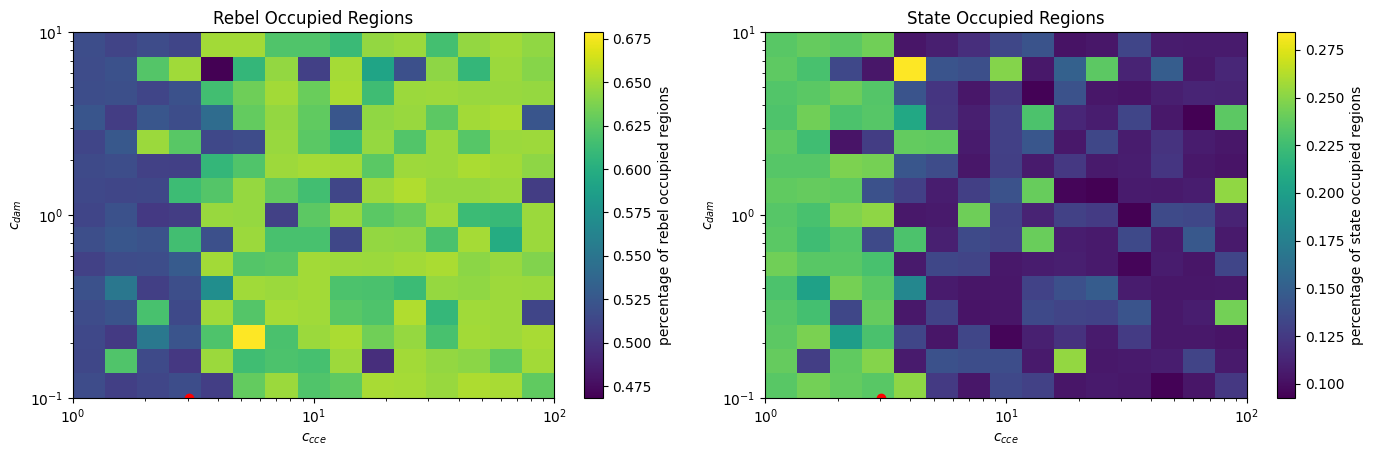

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_cce_ls = np.logspace(0,2,15)
a_dam_ls = np.logspace(-1,1,15)

final_perc_sunni = np.loadtxt("results_memory/cce_dam_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results_memory/cce_dam_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_cce_ls[0], a_cce_ls[-1], len(a_cce_ls) + 1)
y_edges = np.geomspace(a_dam_ls[0], a_dam_ls[-1], len(a_dam_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{cce}$')
axes[0].set_ylabel('$c_{dam}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{cce}$')
axes[1].set_ylabel('$c_{dam}$')
axes[1].set_title('State Occupied Regions')

axes[0].scatter(3.03, 0.1, c = 'red')
axes[1].scatter(3.03, 0.1, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/dam_cce_mem.png', bbox_inches = 'tight', dpi=300)

In [88]:
print(a_dam_ls)

[ 0.1         0.13894955  0.19306977  0.26826958  0.37275937  0.51794747
  0.71968567  1.          1.38949549  1.93069773  2.6826958   3.72759372
  5.17947468  7.19685673 10.        ]


### $c_{Dam}$ - $c_{bce}$

In [ ]:

final_count_state = np.zeros((len(a_bce_ls), len(a_dam_ls)))
final_count_sunni = np.zeros((len(a_bce_ls), len(a_dam_ls)))
final_count_kurds = np.zeros((len(a_bce_ls), len(a_dam_ls)))

for i, y in enumerate(a_bce_ls):
    for j, x in enumerate(a_dam_ls):
# simulation_memory(N of iterations, eps = 0.3, c_pop = 21321, c_os = 7.44, c_dis = 0.076, c_ethn = 3, c_bce = 9.51, 3.03, 0.1, save frame)
        result = simulation_memory(35, 0.3, 21321, 7.44, 0.076, 3, y, 3.03, x, False)
        final_count_state[i, j] = result[0]/8010
        final_count_sunni[i, j] = result[1]/8010
        final_count_kurds[i, j] = result[2]/8010

np.savetxt("results_memory/dam_bce_state.dat", final_count_state, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/dam_bce_sunni.dat", final_count_sunni, delimiter=",", fmt="%.5f")
np.savetxt("results_memory/dam_bce_kurds.dat", final_count_kurds, delimiter=",", fmt="%.5f")

100%|██████████| 35/35 [00:37<00:00,  1.07s/it]


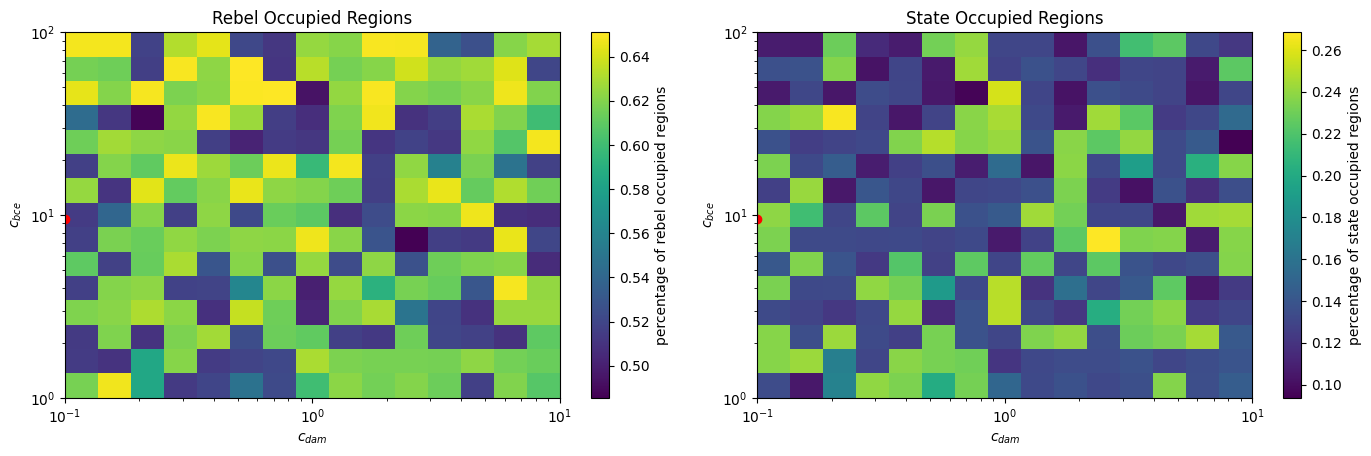

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.66))

a_bce_ls = np.logspace(0,2,15)
a_dam_ls = np.logspace(-1,1,15)

final_perc_sunni = np.loadtxt("results_memory/dam_bce_sunni.dat", delimiter=",")
final_perc_state = np.loadtxt("results_memory/dam_bce_state.dat", delimiter=",")

# Compute "edges" for correct pcolormesh alignment
x_edges = np.geomspace(a_dam_ls[0], a_dam_ls[-1], len(a_dam_ls) + 1)
y_edges = np.geomspace(a_bce_ls[0], a_bce_ls[-1], len(a_bce_ls) + 1)

# --- Rebel / Sunni map ---
mesh1 = axes[0].pcolormesh(x_edges, y_edges, final_perc_sunni, shading='auto', cmap='viridis')
fig.colorbar(mesh1, ax=axes[0], label='percentage of rebel occupied regions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$c_{dam}$')
axes[0].set_ylabel('$c_{bce}$')
axes[0].set_title('Rebel Occupied Regions')

# --- State map ---
mesh2 = axes[1].pcolormesh(x_edges, y_edges, final_perc_state, shading='auto', cmap='viridis')
fig.colorbar(mesh2, ax=axes[1], label='percentage of state occupied regions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$c_{dam}$')
axes[1].set_ylabel('$c_{bce}$')
axes[1].set_title('State Occupied Regions')

axes[0].scatter(0.1, 9.51, c = 'red')
axes[1].scatter(0.1, 9.51, c = 'red')

plt.tight_layout()
plt.savefig(f'images/parameter_space/dam_bce_mem.png', bbox_inches = 'tight', dpi=300)